In [51]:
# !pip install tensorflow==2.12.0
!pip install tensorflow-text==2.12.0

INFO: pip is looking at multiple versions of tf-keras to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 81.8 MB/s eta 0:00:00
  Attempting uninstall: tf-keras
    Found existing installation: tf_keras 2.18.0
    Uninstalling tf_keras-2.18.0:
      Successfully uninstalled tf_keras-2.18.0
  Attempting uninstall: tensorflow-text
    Found existing installation: tensorflow-text 2.18.1
    Uninstalling tensorflow-text-2.18.1:
      Successfully uninstalled tensorflow-text-2.18.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.11.0 requires tensorflow==2.18.0, but you have tensorflow 2.12.0 which is incompatible.
tensorflow-decision-forests 1.11.0 requires tf-keras~=

In [52]:
# impor libraries
import re
import nltk
from openai import OpenAI
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub

from collections import Counter
from wordcloud import WordCloud
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Dropout, Input, Reshape, Layer
from tensorflow.keras.regularizers import L2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report
from imblearn.over_sampling import RandomOverSampler

nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
print("TensorFlow Hub version:", hub.__version__)

TensorFlow Hub version: 0.16.1


In [4]:
pd.set_option('display.max_colwidth', None) # max untuk menampilkan data pada satu baris

In [5]:
data = pd.read_csv('iphone_clean.csv')
df = data.copy()
df

,productAsin,country,date,isVerified,ratingScore,reviewTitle,reviewDescription,reviewUrl,reviewedIn,variant,variantAsin,productVariant,productType
0,B09G9BL5CP,India,11-08-2024,True,4,No charger,"Every thing is good about iPhones, there's nothing compared to it's speed and ios but i was disappointed because there's no charger for it even though Indian judiciary told them to provide , still they haven't made any progress regarding charger. Why should we spend 62k and more than that for iPhones because of it's brand and Acessories comfort size and Features right if that's not there what's point of buying an iPhone.Thank you🙏",https://www.amazon.in/gp/customer-reviews/R345SEIPU4N2XD/ref=cm_cr_getr_d_rvw_ttl?ie=UTF8&ASIN=B09G9BQS98,Reviewed in India on 11 August 2024,Colour: MidnightSize: 256 GB,B09G9BQS98,Apple Iphone 13 (256 GB) - Midnight,Apple Iphone 13
1,B09G9BL5CP,India,16-08-2024,True,5,iPhone 13 256GB,"It look so fabulous, I am android user switched to apple, performance wise iPhone is more better than android due to A15 Bionic chip. I feel pleasant while using iPhone in hand. I like it very much 😍❤️",https://www.amazon.in/gp/customer-reviews/R2HJRJW7MRIVNL/ref=cm_cr_getr_d_rvw_ttl?ie=UTF8&ASIN=B09G9BQS98,Reviewed in India on 16 August 2024,Colour: MidnightSize: 256 GB,B09G9BQS98,Apple Iphone 13 (256 GB) - Midnight,Apple Iphone 13
2,B09G9BL5CP,India,14-05-2024,True,4,Flip camera option nill,"I tried to flip camera while recording but no facility is added here. You have to pause first then you can flip from back to front or vice versa it means you can't continue it, very awkward position. Iphone software should be upgraded so that we can make it go. It's very essential for a content creator. I purchased gimbal dji om se but it could not provided that, it's very essential for a vlogger but I was fed up after finding the basic requirements wasn't built in these products !",https://www.amazon.in/gp/customer-reviews/R3Y7TPOGMY40P/ref=cm_cr_getr_d_rvw_ttl?ie=UTF8&ASIN=B09G9BQS98,Reviewed in India on 14 May 2024,Colour: MidnightSize: 256 GB,B09G9BQS98,Apple Iphone 13 (256 GB) - Midnight,Apple Iphone 13
3,B09G9BL5CP,India,24-06-2024,True,5,Product,100% genuine,https://www.amazon.in/gp/customer-reviews/R1P9A1G2E3ZB7L/ref=cm_cr_getr_d_rvw_ttl?ie=UTF8&ASIN=B09G9BQS98,Reviewed in India on 24 June 2024,Colour: MidnightSize: 256 GB,B09G9BQS98,Apple Iphone 13 (256 GB) - Midnight,Apple Iphone 13
4,B09G9BL5CP,India,18-05-2024,True,5,Good product,Happy to get the iPhone 13 in Amazon offer,https://www.amazon.in/gp/customer-reviews/R1XI5GCQ8WH1LV/ref=cm_cr_getr_d_rvw_ttl?ie=UTF8&ASIN=B09G9BQS98,Reviewed in India on 18 May 2024,Colour: MidnightSize: 256 GB,B09G9BQS98,Apple Iphone 13 (256 GB) - Midnight,Apple Iphone 13
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2955,B09G9D8KRQ,India,11-10-2023,True,1,Very bad experience with i phone 13,Useless phon never buy this heat n useless camera pls don't buy this is my 1 St i phon bt camera quality is 3 Rd class like old Micromax camera and heat every tym,https://www.amazon.in/gp/customer-reviews/R10O9G2QKNPGW4/ref=cm_cr_getr_d_rvw_ttl?ie=UTF8&ASIN=B09G99CW2N,Reviewed in India on 11 October 2023,Colour: (PRODUCT) REDSize: 128 GB,B09G99CW2N,Apple Iphone 13 (128 GB) - Red,Apple Iphone 13
2956,B09G9D8KRQ,India,14-10-2022,True,2,not happy with this apple product,"iam not happy with this product why because charger not provided by apple, this is extra burden to customers, without charger adapter how we can charge, by default adapter should give",https://www.amazon.in/gp/customer-reviews/R2FWWLY2N30LXT/ref=cm_cr_getr_d_rvw_ttl?ie=UTF8&ASIN=B09G99CW2N,Reviewed in India on 14 October 2022,Colour: (PRODUCT) REDSize: 128 GB,B09G99CW2N,Apple Iphone 13 (128 GB) - Red,Apple Iphone 13
2957,B09G9D8KRQ,India,24-02-2022,True,3,Good phone,Good phone,https://www.amazon.in/gp/customer-reviews/R2C76FGTFPCPQ3/ref=cm_cr_getr_d_rvw_ttl?ie=UTF8&ASIN=B09G99CW2N,Reviewed in India on 24 February 2022,Colour: (PRODUCT) 

In [6]:
df['productType'] = df['productType'].str.strip()

In [7]:
df['productType'].unique()

array(['Apple Iphone 13', 'Apple Iphone 15', 'Apple Iphone 14'],
      dtype=object)

In [8]:
df.columns

Index(['productAsin', 'country', 'date', 'isVerified', 'ratingScore',
       'reviewTitle', 'reviewDescription', 'reviewUrl', 'reviewedIn',
       'variant', 'variantAsin', 'productVariant', 'productType'],
      dtype='object')

In [9]:
df['productVariant'].unique()

array(['Apple Iphone 13 (256 GB) - Midnight',
       'Apple Iphone 13 (256 GB) - Pink',
       'Apple Iphone 13 (256 GB) - Blue',
       'Apple Iphone 13 (256 GB) - Green',
       'Apple Iphone 13 (128 GB) - Pink',
       'Apple Iphone 13 (256 GB) - Starlight',
       'Apple Iphone 13 (128 GB) - Green',
       'Apple Iphone 13 (128 GB) - Starlight',
       'Apple Iphone 13 (128 GB) - Midnight',
       'Apple Iphone 13 (128 GB) - Red',
       'Apple Iphone 13 (128 GB) - Blue',
       'Apple Iphone 13 (256 GB) - Red',
       'Apple Iphone 13 (512 GB) - Starlight',
       'Apple Iphone 13 (512 GB) - Red',
       'Apple Iphone 13 (512 GB) - Midnight',
       'Apple Iphone 13 (512 GB) - Pink',
       'Apple Iphone 13 (512 GB) - Blue',
       'Apple Iphone 15 (128 GB) - Pink',
       'Apple Iphone 15 (128 GB) - Yellow',
       'Apple Iphone 15 (256 GB) - Pink',
       'Apple Iphone 15 (256 GB) - Green',
       'Apple Iphone 15 (128 GB) - Green',
       'Apple Iphone 15 (256 GB) - Yellow',
  

In [10]:
df['productType'].unique()

array(['Apple Iphone 13', 'Apple Iphone 15', 'Apple Iphone 14'],
      dtype=object)

In [11]:
df_use = df[['reviewDescription', 'productType']]
df_use

,reviewDescription,productType
0,"Every thing is good about iPhones, there's nothing compared to it's speed and ios but i was disappointed because there's no charger for it even though Indian judiciary told them to provide , still they haven't made any progress regarding charger. Why should we spend 62k and more than that for iPhones because of it's brand and Acessories comfort size and Features right if that's not there what's point of buying an iPhone.Thank you🙏",Apple Iphone 13
1,"It look so fabulous, I am android user switched to apple, performance wise iPhone is more better than android due to A15 Bionic chip. I feel pleasant while using iPhone in hand. I like it very much 😍❤️",Apple Iphone 13
2,"I tried to flip camera while recording but no facility is added here. You have to pause first then you can flip from back to front or vice versa it means you can't continue it, very awkward position. Iphone software should be upgraded so that we can make it go. It's very essential for a content creator. I purchased gimbal dji om se but it could not provided that, it's very essential for a vlogger but I was fed up after finding the basic requirements wasn't built in these products !",Apple Iphone 13
3,100% genuine,Apple Iphone 13
4,Happy to get the iPhone 13 in Amazon offer,Apple Iphone 13
...,...,...
2955,Useless phon never buy this heat n useless camera pls don't buy this is my 1 St i phon bt camera quality is 3 Rd class like old Micromax camera and heat every tym,Apple Iphone 13
2956,"iam not happy with this product why because charger not provided by apple, this is extra burden to customers, without charger adapter how we can charge, by default adapter should give",Apple Iphone 13
2957,Good phone,Apple Iphone 13
2958,While charging mobile it's getting so hot even while using mobile it's get so much heated,Apple Iphone 13


In [12]:
df_use['productType'].value_counts()

,count
productType,
Apple Iphone 13,1715
Apple Iphone 14,996
Apple Iphone 15,249


In [13]:
df_use.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2960 entries, 0 to 2959
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   reviewDescription  2960 non-null   object
 1   productType        2960 non-null   object
dtypes: object(2)
memory usage: 46.4+ KB


In [14]:
# cek nilai unik dataset

# variabel untuk konversi tabel ke list
dfuse_to_list = df_use.to_dict('list')

# list kosong untuk nilai unik
list_unique = []

# looping untuk nilai unik
for col, val in dfuse_to_list.items():
    val = set(val)
    val = list(val)
    list_unique.append([col, val])

# menampilkan dataframe
unique = pd.DataFrame(columns = ['col_name', 'col_unique_val'], data = list_unique)
unique

col_name  \
0  reviewDescription   
1        productType   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

In [15]:
df_use[df_use.duplicated()]

,reviewDescription,productType
58,Nice,Apple Iphone 13
81,Best,Apple Iphone 13
84,Best,Apple Iphone 13
98,Good,Apple Iphone 13
153,Excellent product,Apple Iphone 13
...,...,...
2925,👍👍👍👍👍👍👍,Apple Iphone 13
2926,Good,Apple Iphone 13
2927,Not value for money,Apple Iphone 13
2928,good,Apple Iphone 13


In [16]:
# membuat list stopwords
stop_words_en = set(stopwords.words("english"))
stop_words_en.add('phone')
stop_words_en.add('iphone')
stop_words_en.add('got')
stop_words_en.add('one')
stop_words_en.add('use')
stop_words_en.add('events')
stop_words_en.add('even')
stop_words_en.add('get')
stop_words_en.add('amazon')
stop_words_en.add('also')
stop_words_en.add('using')
stop_words_en.add('product')
stop_words_en.add('came')


# menghilangkan dan menambahkan kata dari daftar stopwords

print(f"Jumlah Stop Words: {len(stop_words_en)}")
print(stop_words_en)
print('')

Jumlah Stop Words: 211
{"he'll", "isn't", 'until', 'if', "i'll", 'once', 'some', 'we', 'but', 've', 'of', 'against', 'in', 'did', 'mightn', 'll', 'can', 'her', 'weren', "they'd", 'one', 'into', 'here', 'them', "we've", 'than', "you'll", 'at', 'be', 'what', 'which', 'whom', 'most', 'and', 'how', 'will', 'having', 'o', 'only', "didn't", 'with', "shouldn't", "haven't", 'has', "i've", 'am', 'each', "it's", "we'd", 'yours', 'couldn', 'itself', 't', 'hasn', 'aren', 'those', 'their', 'down', 'you', 'iphone', 'hers', 'have', 'don', 'over', 'him', 'your', 'below', "he's", 'came', 'got', 'about', 're', 'while', 'he', "needn't", 'ours', 'these', 'also', 'are', 'y', 'is', "you'd", 'themselves', "wasn't", 'd', 'too', 'during', "hasn't", 'its', 'on', 'events', 'again', "she'll", 'any', 'do', 'product', 'wouldn', 'an', 'now', 'after', 'won', 'me', 'yourselves', 'up', 'both', "you've", "she's", 'all', 'ourselves', "i'm", 'mustn', 'shan', "i'd", "we're", 'who', "mightn't", 's', 'shouldn', 'was', "you'r

In [17]:
# fungsi untuk generate worldcloud eda
def wordcloud_eda(text):
    # gabungkan string data
    text = " ".join(text.astype(str))

    # menghapus hashtag
    text = re.sub("#[A-Za-z0-9_]+", " ", text)

    # menghapus kata non-alfabetik
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # menghapus whitespace
    text = text.strip()

    # membuat wordcloud
    wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords = stop_words_en).generate(text)

    # menampilkan wordcloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

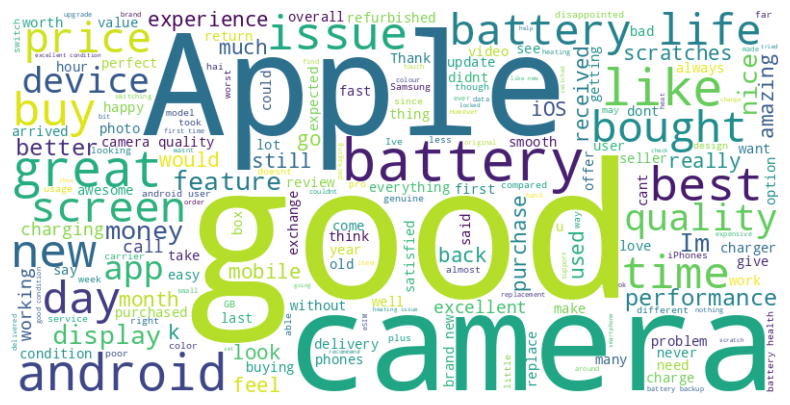

In [18]:
wordcloud_eda(df['reviewDescription'])

In [19]:
# Stemmer
ps = PorterStemmer()

# lemmetizer
wn = WordNetLemmatizer()

In [20]:
# fungsi untuk preprosessing teks
def text_preprocessing(text):
    # lowercase huruf
    text = text.lower()

    # hapus mention
    text = re.sub("@[A-Za-z0-9_]+", " ", text)

    # hapus hashtag
    text = re.sub("#[A-Za-z0-9_]+", " ", text)

    # hapus newline
    text = re.sub(r"\\n", " ",text)

    # hapus whitespace
    text = text.strip()

    # hapus url
    text = re.sub(r"http\S+", " ", text)
    text = re.sub(r"www.\S+", " ", text)

    # hapus non alfabetik
    text = re.sub("[^A-Za-z\s']", " ", text)

    # tokenisasi
    tokens = word_tokenize(text)

    # hapus stopwords
    tokens = [word for word in tokens if word not in stop_words_en]

    # proses stemming
    tokens = [ps.stem(word) for word in tokens]

    # proses lemmetizer
    tokens = [wn.lemmatize(word) for word in tokens]

    # menggabungkan tokens
    text = ' '.join(tokens)

    return text

In [21]:
# perbandingan tulisan setelah di preproses
df_use['reviewDescriptionPreprocess'] = df_use['reviewDescription'].apply(lambda x: text_preprocessing(x))
df_use.head(10)

<ipython-input-21-1184322740>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_use['reviewDescriptionPreprocess'] = df_use['reviewDescription'].apply(lambda x: text_preprocessing(x))


,reviewDescription,productType,reviewDescriptionPreprocess
0,"Every thing is good about iPhones, there's nothing compared to it's speed and ios but i was disappointed because there's no charger for it even though Indian judiciary told them to provide , still they haven't made any progress regarding charger. Why should we spend 62k and more than that for iPhones because of it's brand and Acessories comfort size and Features right if that's not there what's point of buying an iPhone.Thank you🙏",Apple Iphone 13,everi thing good iphon 's noth compar 's speed io disappoint 's charger though indian judiciari told provid still n't made progress regard charger spend k iphon 's brand acessori comfort size featur right 's 's point buy thank
1,"It look so fabulous, I am android user switched to apple, performance wise iPhone is more better than android due to A15 Bionic chip. I feel pleasant while using iPhone in hand. I like it very much 😍❤️",Apple Iphone 13,look fabul android user switch appl perform wise better android due bionic chip feel pleasant hand like much
2,"I tried to flip camera while recording but no facility is added here. You have to pause first then you can flip from back to front or vice versa it means you can't continue it, very awkward position. Iphone software should be upgraded so that we can make it go. It's very essential for a content creator. I purchased gimbal dji om se but it could not provided that, it's very essential for a vlogger but I was fed up after finding the basic requirements wasn't built in these products !",Apple Iphone 13,tri flip camera record facil ad paus first flip back front vice versa mean ca n't continu awkward posit softwar upgrad make go 's essenti content creator purchas gimbal dji om se could provid 's essenti vlogger fed find basic requir n't built product
3,100% genuine,Apple Iphone 13,genuin
4,Happy to get the iPhone 13 in Amazon offer,Apple Iphone 13,happi offer
5,5 star 👍,Apple Iphone 13,star
6,"Great Product... Nothing to say, as the Name APPLE is own identity of this product.. All is well, recommendation is 100% . Just grab this product else you missed something....",Apple Iphone 13,great noth say name appl ident well recommend grab el miss someth
7,Good product 😀💯,Apple Iphone 13,good
8,Nice product,Apple Iphone 13,nice
9,Excellent product,Apple Iphone 13,excel


In [22]:
# data review dan data product
review_col = df_use['reviewDescriptionPreprocess']
product_col = df_use['productType']

In [23]:
review_col

,reviewDescriptionPreprocess
0,everi thing good iphon 's noth compar 's speed io disappoint 's charger though indian judiciari told provid still n't made progress regard charger spend k iphon 's brand acessori comfort size featur right 's 's point buy thank
1,look fabul android user switch appl perform wise better android due bionic chip feel pleasant hand like much
2,tri flip camera record facil ad paus first flip back front vice versa mean ca n't continu awkward posit softwar upgrad make go 's essenti content creator purchas gimbal dji om se could provid 's essenti vlogger fed find basic requir n't built product
3,genuin
4,happi offer
...,...
2955,useless phon never buy heat n useless camera pl n't buy st phon bt camera qualiti rd class like old micromax camera heat everi tym
2956,iam happi charger provid appl extra burden custom without charger adapt charg default adapt give
2957,good
2958,charg mobil 's get hot mobil 's much heat


In [24]:
product_col

,productType
0,Apple Iphone 13
1,Apple Iphone 13
2,Apple Iphone 13
3,Apple Iphone 13
4,Apple Iphone 13
...,...
2955,Apple Iphone 13
2956,Apple Iphone 13
2957,Apple Iphone 13
2958,Apple Iphone 13


In [25]:
df_use['productType'] = df_use['productType'].replace({'Apple Iphone 13': 0, 'Apple Iphone 14': 1,
                                                       'Apple Iphone 15': 2})

<ipython-input-25-1917652289>:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_use['productType'] = df_use['productType'].replace({'Apple Iphone 13': 0, 'Apple Iphone 14': 1,
<ipython-input-25-1917652289>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_use['productType'] = df_use['productType'].replace({'Apple Iphone 13': 0, 'Apple Iphone 14': 1,


In [26]:
# split train+eval dan test
X_train_eval, X_test, y_train_eval, y_test = train_test_split(df_use['reviewDescriptionPreprocess'],
                                                             df_use['productType'],
                                                             test_size = 0.20,
                                                             random_state = 45,
                                                             stratify = df['productType'])

# split train dan eval
X_train, X_eval, y_train, y_eval = train_test_split(X_train_eval,
                                                    y_train_eval,
                                                    test_size = 0.10,
                                                    random_state = 45,
                                                    stratify = y_train_eval)

In [27]:
# cek tiap data
print(f"Jumlah target train: {y_train.shape}")
print(f"Jumlah target test:: {y_test.shape}")

Jumlah target train: (2131,)
Jumlah target test:: (592,)


In [28]:
# cek balance data
y_balancing = y_train.value_counts().reset_index()
y_balancing

,productType,count
0,0,1235
1,1,717
2,2,179


In [29]:
y_balancing[y_balancing['productType'] == 0]['count']

,count
0,1235


In [30]:
y_b_13 = y_balancing[y_balancing['productType'] == 0]['count']
y_b_14 = y_balancing[y_balancing['productType'] == 1]['count']
y_b_15 = y_balancing[y_balancing['productType'] == 2]['count']

In [31]:
# persentase target Apple Iphone 13
(y_b_13 / sum(y_balancing['count'])) * 100

,count
0,57.954012


In [32]:
# persentase target Apple Iphone 14
(y_b_14 / sum(y_balancing['count'])) * 100

,count
1,33.646176


In [33]:
# persentase target Apple Iphone 15
(y_b_15 / sum(y_balancing['count'])) * 100

,count
2,8.399812


In [34]:
X_train_df = X_train.to_frame()

In [35]:
# data balancing
ros = RandomOverSampler(random_state = 45)
X_train_resample, y_train_resample = ros.fit_resample(X_train_df, y_train)

# konversi kembali menjadi series
X_train_resample = X_train_resample['reviewDescriptionPreprocess']

# menampilkan target yang sudah balance
y_train_resample.value_counts()

,count
productType,
0,1235
2,1235
1,1235


In [36]:
# encode menggunakan one hot encoding untuk menghasilkan
# matriks biner
y_train_encoded = to_categorical(y_train_resample)
y_eval_encoded = to_categorical(y_eval)
y_test_encoded = to_categorical(y_test)

y_train_encoded

array([[1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)

In [37]:
# mendapatkan vocabulary
Vectorise = CountVectorizer()
X_train_vec_1 = Vectorise.fit_transform(X_train_resample)
X_test_vec_1 = Vectorise.transform(X_test)

# jumlah vocab dan panjang token maksimum dalam satu dokumen
total_vocab = len(Vectorise.vocabulary_.keys())
max_sen_len = max([len(i.split(" ")) for i in X_train_resample])

print(f"Total vocab: {total_vocab} token")
print(f"Panjang maksimum kalimat(token): {max_sen_len}")

Total vocab: 3718 token
Panjang maksimum kalimat(token): 331


In [38]:
# input adalah list string
X_train_resample_1 = X_train_resample.astype(str).tolist()
X_eval_1 = X_eval.astype(str).tolist()
X_test_1 = X_test.astype(str).tolist()

# Ubah jadi tf.constant bertipe tf.string
X_train_resample_1 = tf.constant(X_train_resample_1, dtype=tf.string)
X_eval_1 = tf.constant(X_eval_1, dtype=tf.string)
X_test_1 = tf.constant(X_test_1, dtype=tf.string)

In [58]:
import tensorflow_text as tf_text

seed = 30
tf.keras.backend.clear_session()
tf.random.set_seed(seed)

text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name="text")

# TF‑Hub layers
preprocess = hub.KerasLayer(
    "https://kaggle.com/models/tensorflow/bert/TensorFlow2/en-uncased-preprocess/3",
    name="preprocess",
)
encoder = hub.KerasLayer(
    "https://www.kaggle.com/models/tensorflow/bert/TensorFlow2/bert-en-uncased-l-10-h-128-a-2/2",
    trainable=True,
    name="encoder",
)

encoder_inputs  = preprocess(text_input)           # dict with word‑piece ids, masks, …
encoder_outputs = encoder(encoder_inputs)          # dict with 'pooled_output' etc.
x = encoder_outputs["pooled_output"]               # (None, 128)

# Down‑stream layers
x = tf.keras.layers.Reshape((128, 1))(x)
x = tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(64,
            kernel_initializer=tf.keras.initializers.HeUniform(seed))
    )(x)
x = tf.keras.layers.Dropout(0.1)(x)
preds = tf.keras.layers.Dense(3, activation="softmax")(x)

model = tf.keras.Model(inputs=text_input, outputs=preds, name="bert_lstm")
model.compile(optimizer="adamax",
              loss="categorical_crossentropy",
              metrics=["accuracy"])

model.summary()

# early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# model checkpoint
model_checkpoint = ModelCheckpoint(
    filepath='model_lstm_bert.keras',
    monitor='val_loss',
    save_best_only=False,
    save_weights_only=False,
    mode='min',
    verbose=1
)

Model: "bert_lstm"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 preprocess (KerasLayer)        {'input_type_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128)}                                              

In [59]:
model_lstm_bert = model.fit(X_train_resample_1, y_train_encoded, epochs=20, validation_data=(X_eval_1, y_eval_encoded), callbacks=[model_checkpoint, early_stopping])

Epoch 1/20
116/116 [==============================] - ETA: 0s - loss: 1.1070 - accuracy: 0.3339
Epoch 1: saving model to model_lstm_bert.keras
116/116 [==============================] - 256s 2s/step - loss: 1.1070 - accuracy: 0.3339 - val_loss: 1.1219 - val_accuracy: 0.2996
Epoch 2/20
116/116 [==============================] - ETA: 0s - loss: 1.0438 - accuracy: 0.4405
Epoch 2: saving model to model_lstm_bert.keras
116/116 [==============================] - 228s 2s/step - loss: 1.0438 - accuracy: 0.4405 - val_loss: 1.0671 - val_accuracy: 0.2954
Epoch 3/20
116/116 [==============================] - ETA: 0s - loss: 0.9661 - accuracy: 0.5333
Epoch 3: saving model to model_lstm_bert.keras
116/116 [==============================] - 221s 2s/step - loss: 0.9661 - accuracy: 0.5333 - val_loss: 1.0079 - val_accuracy: 0.4093
Epoch 4/20
116/116 [==============================] - ETA: 0s - loss: 0.8772 - accuracy: 0.5897
Epoch 4: saving model to model_lstm_bert.keras
116/116 [=======================

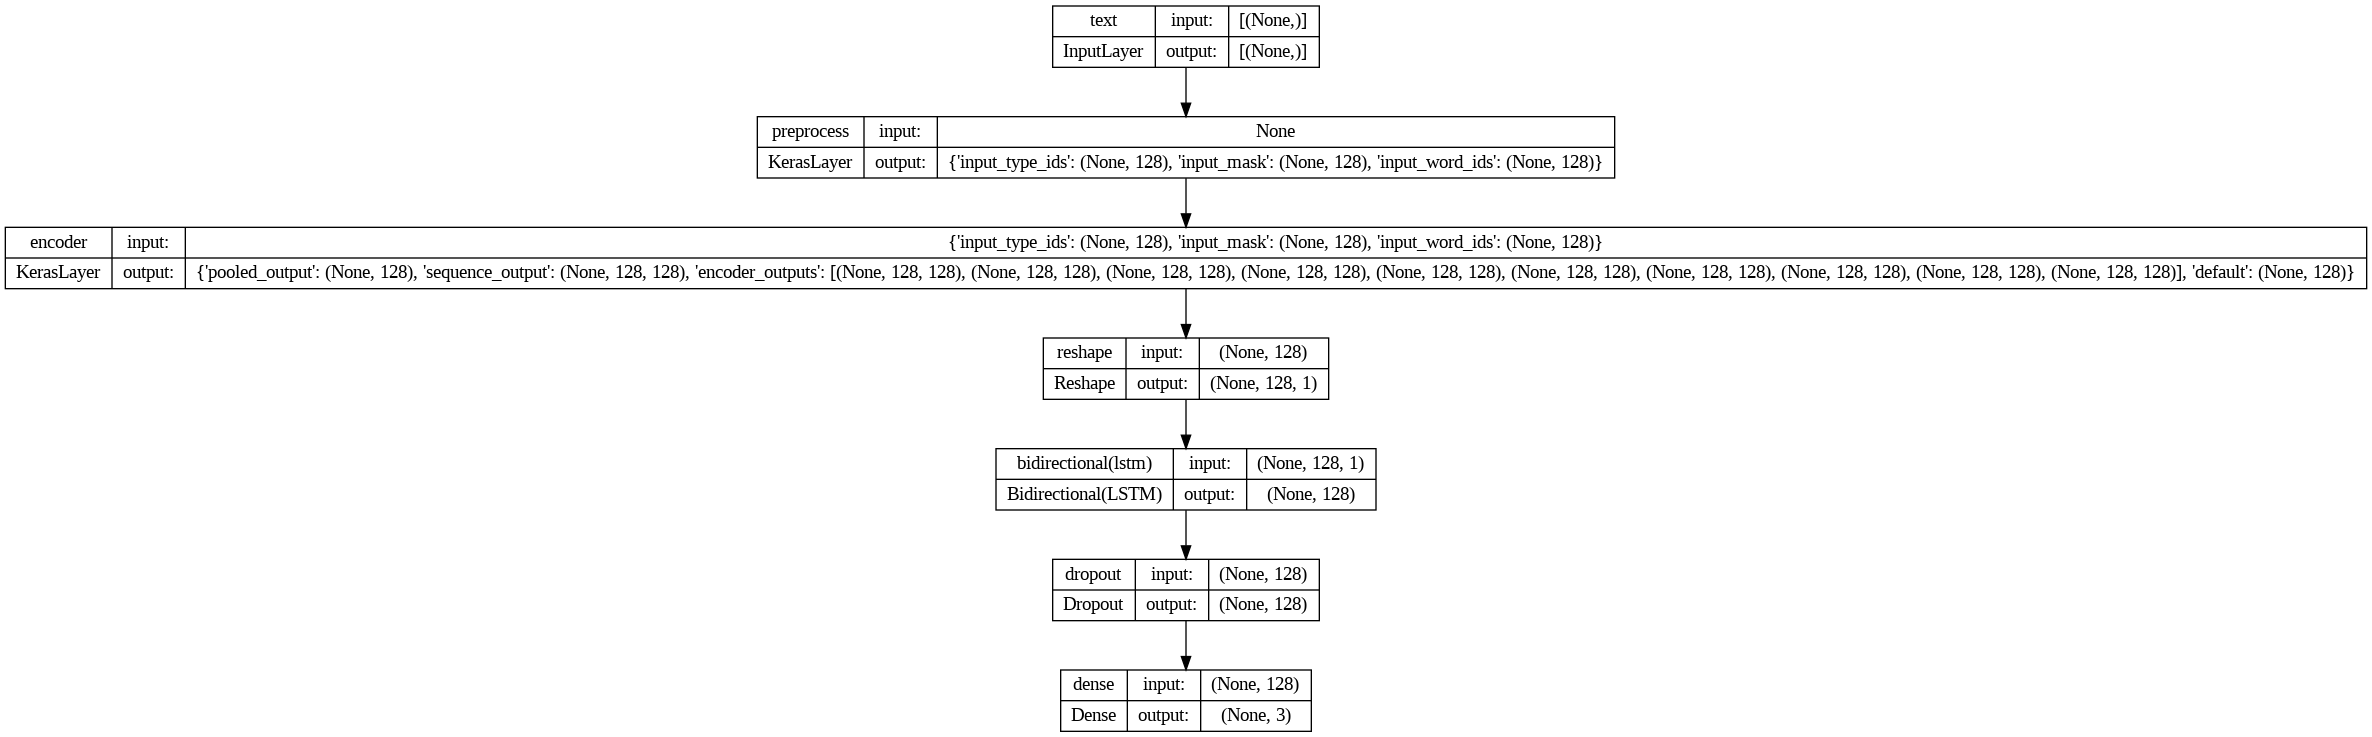

In [61]:
tf.keras.utils.plot_model(model, show_shapes = True)

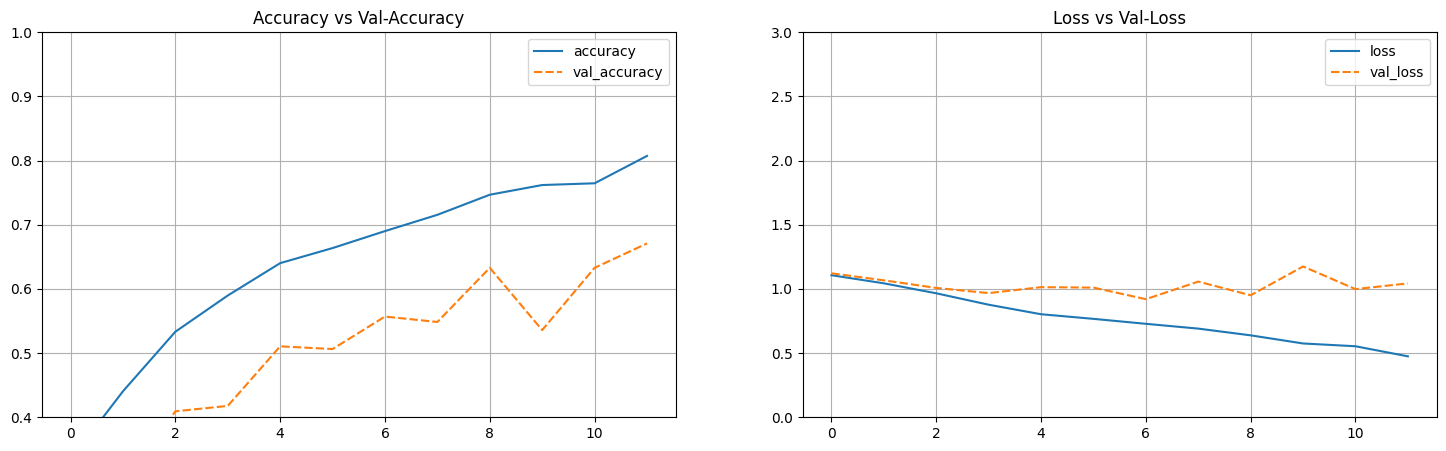

In [62]:
# Plot hasil training

model_lstm_bert_hist = pd.DataFrame(model_lstm_bert.history)

plt.figure(figsize=(18, 5))
plt.subplot(1, 2, 1)
sns.lineplot(data = model_lstm_bert_hist[['accuracy', 'val_accuracy']])
plt.ylim(0.400, 1)
plt.grid()
plt.title('Accuracy vs Val-Accuracy')

plt.subplot(1, 2, 2)
sns.lineplot(data = model_lstm_bert_hist[['loss', 'val_loss']])
plt.ylim(0,3)
plt.grid()
plt.title('Loss vs Val-Loss')
plt.show()

In [64]:
# proses prediksi set train dan test
y_train_pred_2 = model.predict(X_train_resample_1)  # predict berbentuk proba
y_train_pred_2 = np.argmax(y_train_pred_2, axis=1)  # konversi ke class

y_test_pred_2 = model.predict(X_test_1)  # predict berbentuk proba
y_test_pred_2= np.argmax(y_test_pred_2, axis=1)  # konversi ke class

# konversi target original ke label class
y_train_true_2 = np.argmax(y_train_encoded, axis=1) if len(y_train_encoded.shape) > 1 and y_train_encoded.shape[1] > 1 else y_train_resample
y_test_true_2 = np.argmax(y_test_encoded, axis=1) if len(y_test_encoded.shape) > 1 and y_test_encoded.shape[1] > 1 else y_test

19/19 [==============================] - 10s 518ms/step


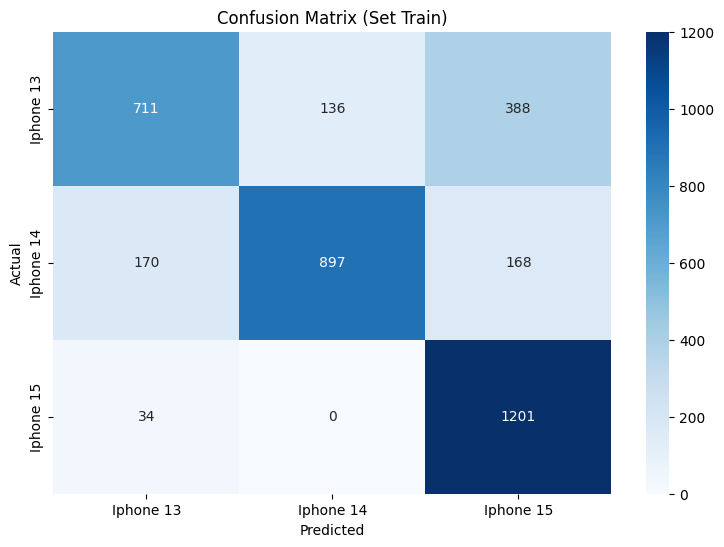

Classification Report (Set Train):
              precision    recall  f1-score   support

   Iphone 13       0.78      0.58      0.66      1235
   Iphone 14       0.87      0.73      0.79      1235
   Iphone 15       0.68      0.97      0.80      1235

    accuracy                           0.76      3705
   macro avg       0.78      0.76      0.75      3705
weighted avg       0.78      0.76      0.75      3705



In [65]:
# deklarasi confusion matriks set train
cm = confusion_matrix(y_train_true_2, y_train_pred_2)

# menampilkan confusion matrix
class_names = ['Iphone 13', 'Iphone 14', 'Iphone 15']
report = classification_report(y_train_true_2, y_train_pred_2, target_names=class_names, zero_division=0)
plt.figure(figsize=(9, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Set Train)')
plt.show()

# menampilkan classification report
print("Classification Report (Set Train):")
print(report)

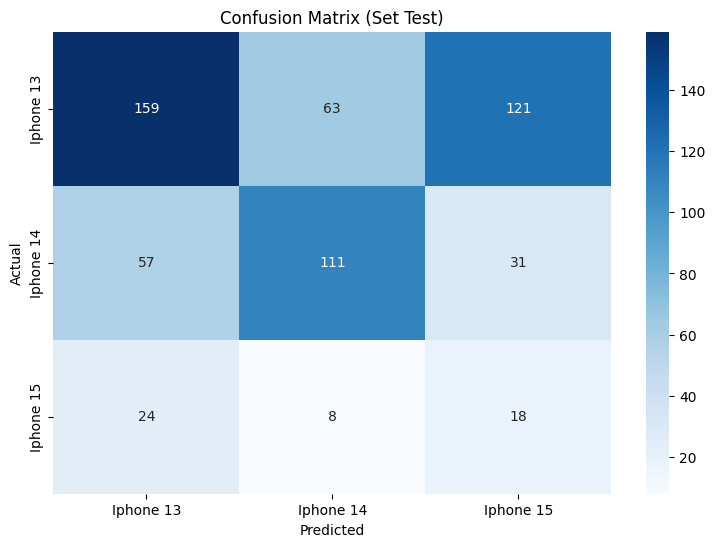

Classification Report (Set Test):
              precision    recall  f1-score   support

   Iphone 13       0.66      0.46      0.55       343
   Iphone 14       0.61      0.56      0.58       199
   Iphone 15       0.11      0.36      0.16        50

    accuracy                           0.49       592
   macro avg       0.46      0.46      0.43       592
weighted avg       0.60      0.49      0.53       592



In [66]:
# deklarasi confusion matriks set test
cm = confusion_matrix(y_test_true_2, y_test_pred_2)

# menampilkan confusion matrix
class_names = ['Iphone 13', 'Iphone 14', 'Iphone 15']
report = classification_report(y_test_true_2, y_test_pred_2, target_names=class_names, zero_division=0)
plt.figure(figsize=(9, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Set Test)')
plt.show()

# menampilkan classification report set test
print("Classification Report (Set Test):")
print(report)